In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Overview

This code implements a Deep Q-Network (DQN) training loop for an Atari game environment (Space Invaders) using Gymnasium, PyTorch, and a replay buffer for experience replay. The main goal is to train an agent to learn an optimal policy for playing Space Invaders by interacting with the environment, storing experiences, and using those experiences to update the policy network’s parameters.

Key components include:

- Environment Setup: Uses vectorized environments (SyncVectorEnv) for parallelization.
- Neural Network (DQN): Convolutional layers for processing the visual input from the Atari environment, followed by fully-connected layers to output Q-values for each action.
- Replay Memory: A thread-safe replay buffer storing experience tuples for training.
- Training Loop: Iteratively interacts with the environment, collects experiences, optimizes the Q-network with mini-batch gradient descent, updates a target network periodically, and decays epsilon for the epsilon-greedy policy.

## 1. Different functions

### 1.1 Set Seed Function
Sets all relevant random seeds for reproducibility. Ensures that experiments are consistent across runs.

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

### 1.2 Select Action Function
This function still implements the epsilon-greedy policy but includes additional preprocessing steps for the state. With probability epsilon, it selects a random action from the action space, encouraging exploration. Otherwise, it converts the input state into a PyTorch tensor (if it isn't one already), makes sure the state has the proper dimensions, and then passes it through the policy network to get Q-values. The action chosen in this second case is the one with the highest Q-value, promoting exploitation of what the agent has learned.

In [ ]:
def select_action(state, policy_net, epsilon, action_space):
    if random.random() < epsilon:
        return action_space.sample()  # Exploration
    else:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = policy_net(state)
            action = q_values.argmax(dim=1).item()
        return action

### 1.3 Optimize Model Function
This function is used to optimize the model. It samples a batch of transitions from the replay buffer and calculates the loss. The loss is then used to update the policy network. The target network is updated using the Polyak averaging method. 
Uses Huber loss to stabilize training by being less sensitive to outliers.
Performs standard backpropagation and gradient clipping to avoid exploding gradients.
Returns the loss value for logging.

In [ ]:
def optimize_model(batch_size, memory, policy_net, target_net, optimizer, criterion, gamma):
    """
    Samples a batch from replay memory and performs a gradient descent step.
    """
    sample = memory.sample(batch_size)
    if sample is None:
        return None  # Not enough samples to perform optimization

    states, actions_batch, rewards_batch, next_states, dones_batch = sample

    states_tensor = torch.FloatTensor(states).to(device)
    actions_tensor = torch.LongTensor(actions_batch).unsqueeze(1).to(device)
    rewards_tensor = torch.FloatTensor(rewards_batch).to(device)
    next_states_tensor = torch.FloatTensor(next_states).to(device)
    dones_tensor = torch.FloatTensor(dones_batch).to(device)

    current_q_values = policy_net(states_tensor).gather(1, actions_tensor).squeeze(1)
    next_q_values = target_net(next_states_tensor).max(dim=1)[0]
    expected_q_values = rewards_tensor + gamma * next_q_values * (1 - dones_tensor)

    loss = criterion(current_q_values, expected_q_values.detach())

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=10)
    optimizer.step()

    return loss.item()

## 1.4 The Deep Q Network
This DQN model takes in a stack of preprocessed game frames and outputs the estimated Q-values for each possible action. It begins with three convolutional layers that extract visual features from the input images, helping the network understand what’s happening on the screen. After flattening the output of the convolutions into a single feature vector, the model passes it through a fully connected layer to learn higher-level patterns, and then through a final output layer that produces one Q-value per action.

The Q-values represent the network’s estimate of how good it is to take a certain action in the current state. By using ReLU activations and normalizing inputs, this architecture follows the standard DQN approach for handling image-based input and provides a solid foundation for learning effective policies in Atari games.

In [ ]:
class DQN(nn.Module):
    def __init__(self, action_size):
        super(DQN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        
        self.fc1 = nn.Linear(7 * 7 * 64, 512)
        self.fc2 = nn.Linear(512, action_size)
        
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='linear')
        nn.init.constant_(self.fc2.bias, 0)

    def forward(self, x):
        x = x / 255.0  
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        q_values = self.fc2(x)
        return q_values

## 2. Hyperparameters

num_episodes = 5000:
- This specifies the number of episodes (complete runs through the environment) that the agent will experience during training. Each episode typically ends when the agent reaches a terminal state or after a fixed number of steps.

batch_size = 64:
- This is the number of experiences (state, action, reward, next state) sampled from the replay memory to update the neural network. A larger batch size can provide more stable updates but requires more memory and computation.

gamma = 0.99:
- This is the discount factor, which determines the importance of future rewards. A value close to 1.0 means that future rewards are considered almost as important as immediate rewards.

epsilon_start = 1.0:
- This is the initial value of epsilon in the epsilon-greedy policy. Epsilon represents the probability of choosing a random action instead of the action suggested by the policy. Starting with a high epsilon encourages exploration.

epsilon_end = 0.1:
- This is the minimum value of epsilon. Over time, epsilon will decay from epsilon_start to epsilon_end, reducing the amount of exploration and increasing exploitation of the learned policy.

epsilon_decay = 0.995:
- This is the decay rate for epsilon. After each episode, epsilon is multiplied by this factor, gradually reducing the exploration rate.

target_update = 100:
- This specifies how often (in terms of episodes) the target network is updated with the weights of the policy network. The target network helps to stabilize training by providing consistent targets during updates.

save_frequency = 100:
- This indicates how often (in terms of episodes) the model's parameters are saved to disk. Regular saving allows for recovery and analysis of the model's performance at different stages of training.

memory_capacity = 100000:
- This is the maximum number of experiences that can be stored in the replay memory. Once the memory is full, older experiences are discarded to make room for new ones.

max_steps_per_episode = 500:
- This is the maximum number of steps the agent can take in a single episode. Limiting the number of steps can help in faster experimentation and prevent the agent from getting stuck in long episodes.


In [ ]:
num_episodes = 5000
batch_size = 64
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay = 0.995
target_update = 100
save_frequency = 100
memory_capacity = 100000
max_steps_per_episode = 500

## 3. Training loop

The training loop is all about helping our agent get better at playing the Atari game space invaders step by step. First, we set the stage by creating one Atari environment and applying some filters to its observations, like resizing and stacking frames. We then set up two neural networks: our main policy network, which tries to guess how good each action is, and our target network, which we use to create stable learning targets. We also prepare a replay memory where we’ll store past experiences, and we pick our optimizer and various other training settings, like how many episodes to run and how quickly to move from random exploration to relying on what we’ve learned.

Once we start an episode, we reset the environment to get a fresh state. In the beginning, the agent doesn’t know anything, so it picks actions mostly at random. This randomness is controlled by a number called epsilon. Over time, as we gather more data and the agent starts to pick up patterns, epsilon goes down, so the agent depends less on luck and more on its own understanding.

As each episode moves forward, the agent sees the current game frame, chooses an action (either random or based on the policy network’s best guess), and takes a step. The environment then shows the next frame, gives a reward, and indicates if the game is over. We store these “experience tuples” (state, action, reward, next state, done) in the replay memory. Later, we’ll grab random batches of these tuples to train the agent. By mixing old and new experiences, the agent can learn from a variety of situations instead of just whatever happened most recently.

When an episode finishes or hits a certain time limit, we check the reward the agent earned. This gives us a quick sense of how well it’s doing. If we have enough experiences stored, we run a training step: we take a batch of past experiences, ask the policy network how valuable certain actions were, compare those estimates to the more stable estimates we get from the target network, and measure the difference. That difference—our loss—tells us how to adjust the policy network’s parameters so it improves at evaluating actions.

As we keep running episodes, we gradually lower epsilon so the agent relies more on learned strategies than random actions. Every so often, we also copy the policy network’s weights into the target network to keep our learning targets consistent and stable. We save snapshots of our model and record performance metrics as we go, so we can track progress and return later to see how things improved over time.

By repeating this process—resetting the environment at the start of each episode, letting the agent play the game, storing what it did, training on those stored experiences, and slowly shifting from exploration to exploitation—the agent moves from making random guesses to following a real plan. Over time, it figures out which actions lead to better outcomes, making it increasingly skilled at the game.

In [ ]:
def main():
    # Set random seeds for reproducibility
    set_seed(963)

    # Hyperparameters
    num_episodes = 1000
    batch_size = 64
    gamma = 0.99
    epsilon_start = 1.0
    epsilon_end = 0.1
    epsilon_decay = 0.995
    target_update = 10
    save_frequency = 10
    memory_capacity = 150000
    num_envs = 16         # Start with a single environment

    # Initialize vectorized environments
    envs = SyncVectorEnv([make_env() for _ in range(num_envs)])
    action_size = envs.single_action_space.n

    # Initialize networks
    policy_net = DQN(action_size).to(device)
    target_net = DQN(action_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()  # Set target network to evaluation mode

    # Define optimizer and loss function
    optimizer = optim.Adam(policy_net.parameters(), lr=1e-4, weight_decay=1e-5)
    criterion = nn.SmoothL1Loss()  # Huber Loss

    # Initialize replay memory
    memory = ReplayMemory(memory_capacity)

    # Epsilon for epsilon-greedy action selection
    epsilon = epsilon_start

    # Tracking metrics
    total_rewards = []
    loss_values = []
    epsilon_values = []
    best_reward = float('-inf')

    # Training loop with progress bar
    episode_bar = tqdm(range(1, num_episodes + 1), desc="Training Progress", unit="episode")
    for episode in episode_bar:
        # Reset environments and get initial observations
        observations, infos = envs.reset()
        episode_rewards_env = np.zeros(num_envs)
        done_flags = np.array([False] * num_envs)

        step = 0  # Step counter to prevent infinite loops
        max_steps_per_episode = 1000  # Maximum steps per episode

        while not np.all(done_flags) and step < max_steps_per_episode:
            # Select actions for each environment
            actions = []
            for idx, obs in enumerate(observations):
                action = select_action(obs, policy_net, epsilon, envs.single_action_space)
                actions.append(action)

            # Take a step in all environments
            next_observations, rewards, terminations, truncations, infos = envs.step(actions)
            dones = terminations | truncations  # Combine terminations and truncations

            # Store experiences in replay memory
            for i in range(num_envs):
                memory.push(observations[i], actions[i], rewards[i], next_observations[i], dones[i])
                episode_rewards_env[i] += rewards[i]
                done_flags[i] = dones[i]

            # Update observations
            observations = next_observations
            step += 1

        # Compute average reward for the episode
        avg_reward = np.mean(episode_rewards_env)
        total_rewards.append(avg_reward)

        # Perform optimization if enough samples are available
        loss = optimize_model(batch_size, memory, policy_net, target_net, optimizer, criterion, gamma)
        if loss is not None:
            loss_values.append(loss)

        # Decay epsilon
        if epsilon > epsilon_end:
            epsilon *= epsilon_decay
            epsilon = max(epsilon, epsilon_end)
        epsilon_values.append(epsilon)

        # Update target network
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # Save the model periodically
        if episode % save_frequency == 0:
            model_path = f'policy_net_episode_{episode}.pth'
            torch.save(policy_net.state_dict(), model_path)

        # Save the best model
        if avg_reward > best_reward:
            best_reward = avg_reward
            torch.save(policy_net.state_dict(), 'best_policy_net.pth')

        # Prepare loss string
        loss_str = f"{loss:.4f}" if loss is not None else "N/A"

        # Update progress bar with metrics
        episode_bar.set_postfix({
            'Avg Reward': f"{avg_reward:.2f}",
            'Epsilon': f"{epsilon:.4f}",
            'Best Reward': f"{best_reward:.2f}",
            'Loss': f"{loss_str}"
        })

# 4. Reward Analysis
The results indicate that while our DQN agent can occasionally achieve relatively high scores (up to 585 around episode 4070), it does not display a clear, sustained improvement trend over the course of training. On average, the agent attains around 215 points per episode, with a median close to this value, suggesting a generally moderate level of performance. However, the large standard deviation (approximately 121) and the persistent variability in the reward distribution suggest that the policy never converges to a consistently effective strategy.

The mode of the reward distribution is 0, indicating that the agent still frequently experiences episodes with no points scored. This, coupled with the erratic fluctuations seen in both the raw reward scatter plot and the rolling standard deviation, implies that the agent is not reliably exploiting learned policies. Although the moving average line hovers in a moderate range, it does not show a steady upward trajectory that would indicate increasingly stable, high-level play.

In short, our current setup does allow the agent to outperform a random baseline in some instances, but it fails to consistently maintain or improve upon its best episodes. To address this, we may need to revisit key training parameters and techniques—such as the exploration rate schedule, network architecture, or replay buffer strategies—to help the agent more reliably identify and exploit profitable behaviors in the game.

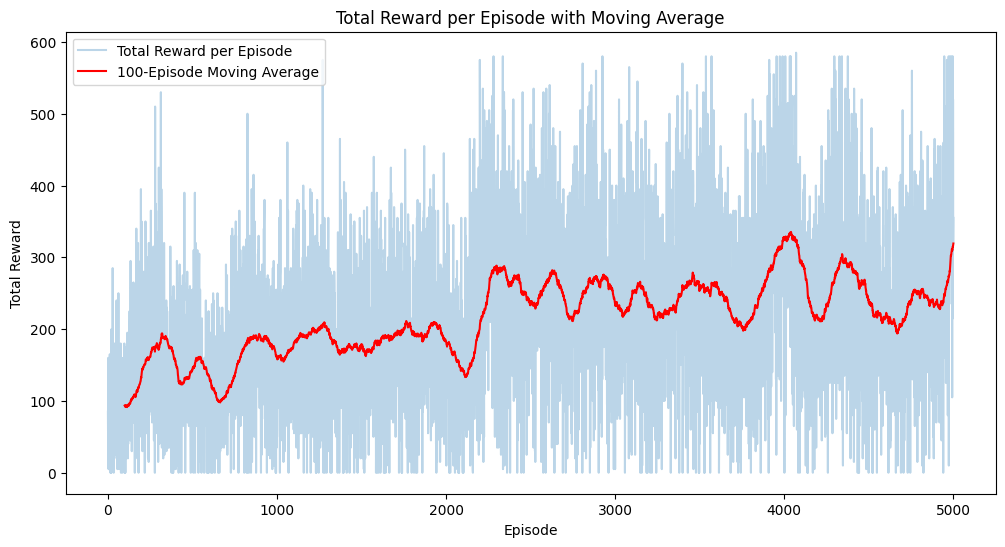

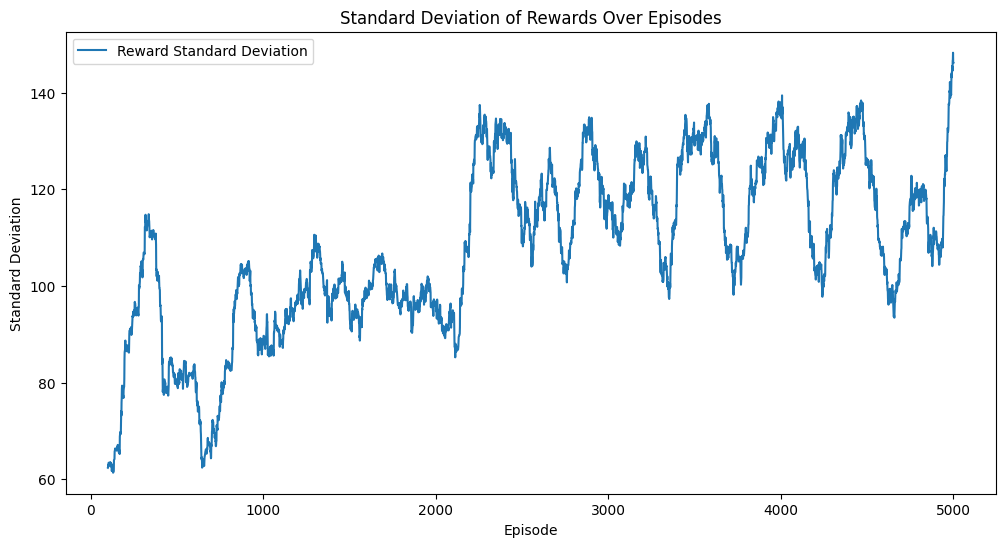

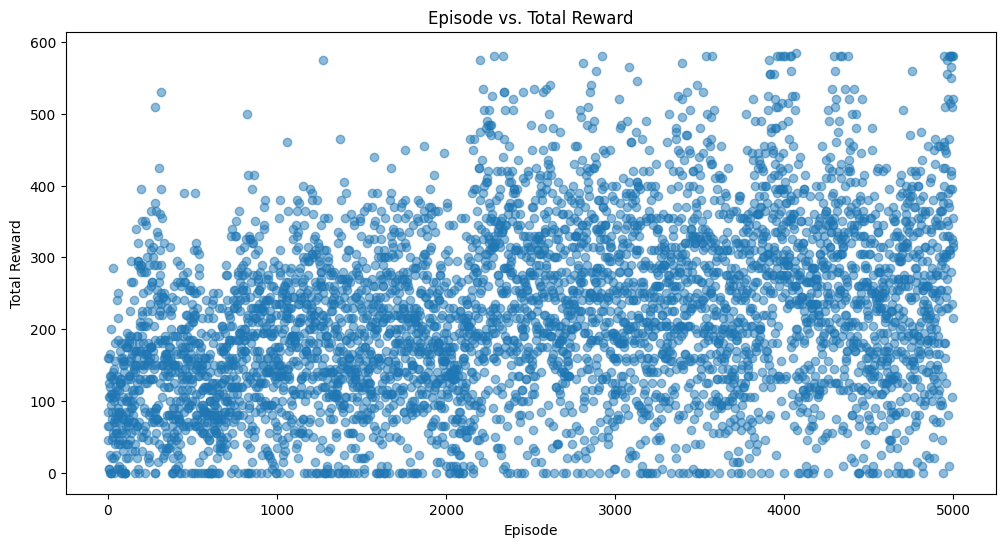

Summary Statistics:
count    5000.000000
mean      215.342000
std       121.076153
min         0.000000
25%       125.000000
50%       205.000000
75%       295.000000
max       585.000000
Name: Total_Reward, dtype: float64

Mode of the Values: [0]

Best Value: 585.0 at Episde 4070.0


In [6]:
def analyze_rewards(csv_file):
    df = pd.read_csv(csv_file)
    
    # Calculate moving average
    df['Moving_Avg'] = df['Total_Reward'].rolling(window=100).mean()
    
    # Plotting Total Reward and Moving Average
    plt.figure(figsize=(12,6))
    plt.plot(df['Episode'], df['Total_Reward'], alpha=0.3, label='Total Reward per Episode')
    plt.plot(df['Episode'], df['Moving_Avg'], label='100-Episode Moving Average', color='red')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode with Moving Average')
    plt.legend()
    plt.show()
    
    # Plotting Standard Deviation
    df['Reward_Std'] = df['Total_Reward'].rolling(window=100).std()
    plt.figure(figsize=(12,6))
    plt.plot(df['Episode'], df['Reward_Std'], label='Reward Standard Deviation')
    plt.xlabel('Episode')
    plt.ylabel('Standard Deviation')
    plt.title('Standard Deviation of Rewards Over Episodes')
    plt.legend()
    plt.show
    
    # Scatter Plot
    plt.figure(figsize=(12,6))
    plt.scatter(df['Episode'], df['Total_Reward'], alpha=0.5)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Episode vs. Total Reward')
    plt.show()

    summary = df['Total_Reward'].describe()
    mode = df['Total_Reward'].mode()
    print("Summary Statistics:")
    print(summary)
    print(f"\nMode of the Values: {mode.tolist()}")
    best_entry = df.loc[df['Total_Reward'].idxmax()]
    print(f"\nBest Value: {best_entry['Total_Reward']} at Episde {best_entry['Episode']}")

# Run the analysis
analyze_rewards('total_rewards.csv')
